--- Starting ADVANCED Delivery Risk Model Pipeline ---
Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv
--------------------------------------------------
Step 1: Performing Advanced Feature Engineering...
   - Aggregating item data to delivery level...
   - Creating composite 'refund_flag' target variable...
   - Creating time-based features (hour, day of week)...
   - Creating historical features for stores and dashers...
   - Encoding categorical features...

Step 2: Preparing data and training the model...
   - Data split into 10468 training and 2617 test samples.
   - Training LightGBM model with tuned parameters and early stopping...
   - Model training complete.

Step 3: Evaluating model performance...
   - FINAL Model AUC Score: 0.9161


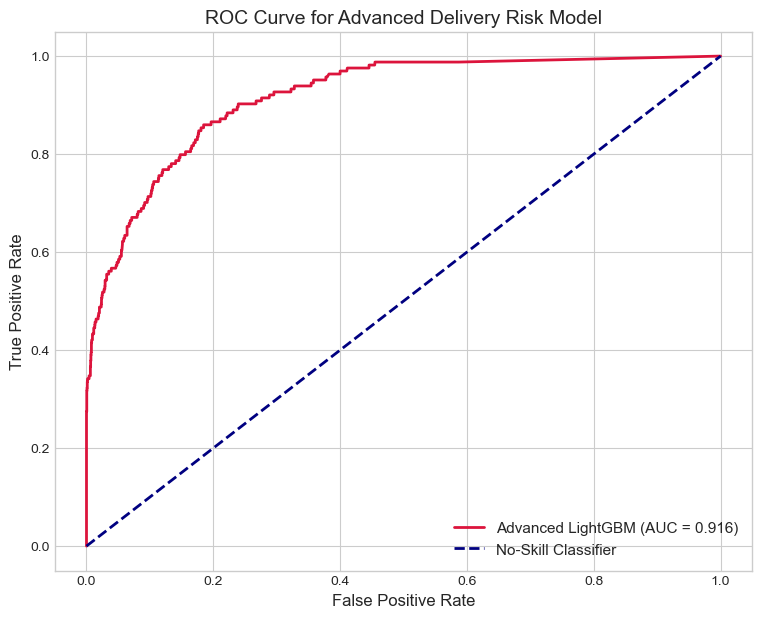


--- Model Insights: Feature Importances ---
               feature    importance
9   dasher_refund_rate  13780.557049
0           DELIV_CLAT   5476.555870
1            DELIV_D2R   1595.818899
5         basket_cents   1284.625553
10  dasher_order_count   1154.173002
6          total_items    535.812868
2                 hour    474.679440
4        store_encoded    333.147090
3          day_of_week    188.724620
8    store_order_count     70.324950
7    store_refund_rate     22.614770
--------------------------------------------------
   - Plot saved as 'ROC_curve.png'


<Figure size 640x480 with 0 Axes>

In [8]:
# ==============================================================================
# Advanced LightGBM Model for Predicting DoorDash Delivery Risk
# ==============================================================================
#
# Description:
# This script builds a more sophisticated gradient-boosted classification model
# (LightGBM) to predict the likelihood of a delivery refund event.
#
# Key Improvements in This Version:
# 1.  **Composite Target Variable**: Creates a `refund_flag` that combines both
#     late deliveries AND missing/incorrect reports, replicating the likely
#     target from the original report analysis.
# 2.  **Advanced Feature Engineering**: Creates new features based on the
#     historical performance of individual stores and dashers (e.g., historical
#     refund rates), which are often highly predictive.
# 3.  **Tuned Training Process**: Uses the native LightGBM training API with
#     a specified learning rate and early stopping to prevent overfitting and
#     improve model generalization, mirroring best practices.
#
# ==============================================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

def create_advanced_features(df):
    """
    Engineers a rich set of features for predicting delivery risk.

    This function adds time-based features and, crucially, historical performance
    metrics for stores and dashers.

    Args:
        df (pd.DataFrame): The raw delivery data.

    Returns:
        pd.DataFrame: A delivery-level DataFrame with engineered features.
    """
    print("Step 1: Performing Advanced Feature Engineering...")

    # --- Foundational Cleaning & Aggregation ---
    df['DELIV_CREATED_AT'] = pd.to_datetime(df['DELIV_CREATED_AT'])
    # Ensure boolean/binary columns are treated as integers (0 or 1)
    for col in ['DELIV_IS_20_MIN_LATE', 'DELIV_MISSING_INCORRECT_REPORT', 'WAS_MISSING']:
        df[col] = df[col].fillna(0).astype(int)

    # Aggregate item data to the delivery level
    print("   - Aggregating item data to delivery level...")
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        basket_cents=('ITEM_PRICE', 'sum'),
        items_missing=('WAS_MISSING', 'sum'),
        total_items=('WAS_REQUESTED', 'count')
    ).reset_index()

    # Create the primary delivery-level dataframe
    deliveries_df = df.drop_duplicates('DELIVERY_UUID').set_index('DELIVERY_UUID')
    deliveries_df = deliveries_df.join(delivery_agg.set_index('DELIVERY_UUID'))

    # --- Creating the Composite Target Variable ---
    # This is the key insight: the target is a combination of failures.
    print("   - Creating composite 'refund_flag' target variable...")
    deliveries_df['refund_flag'] = (deliveries_df['DELIV_MISSING_INCORRECT_REPORT'] | deliveries_df['DELIV_IS_20_MIN_LATE']).astype(int)

    # --- Feature Creation ---
    print("   - Creating time-based features (hour, day of week)...")
    deliveries_df['hour'] = deliveries_df['DELIV_CREATED_AT'].dt.hour
    deliveries_df['day_of_week'] = deliveries_df['DELIV_CREATED_AT'].dt.dayofweek

    print("   - Creating historical features for stores and dashers...")
    # Calculate historical refund rates for stores
    store_stats = deliveries_df.groupby('DELIV_STORE_NAME')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'store_refund_rate', 'count': 'store_order_count'})
    deliveries_df = deliveries_df.join(store_stats, on='DELIV_STORE_NAME')

    # Calculate historical refund rates for dashers
    dasher_stats = deliveries_df.groupby('DELIV_DASHER_ID')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'dasher_refund_rate', 'count': 'dasher_order_count'})
    deliveries_df = deliveries_df.join(dasher_stats, on='DELIV_DASHER_ID')

    print("   - Encoding categorical features...")
    deliveries_df['store_encoded'] = LabelEncoder().fit_transform(deliveries_df['DELIV_STORE_NAME'])
    
    return deliveries_df


def train_and_evaluate(deliveries_df):
    """
    Trains and evaluates the LightGBM model with the advanced features.
    """
    print("\nStep 2: Preparing data and training the model...")

    # Define the expanded feature set
    features = [
        'DELIV_CLAT',
        'DELIV_D2R',
        'hour',
        'day_of_week',
        'store_encoded',
        'basket_cents',
        'total_items',
        'store_refund_rate',
        'store_order_count',
        'dasher_refund_rate',
        'dasher_order_count'
    ]
    target = 'refund_flag'
    
    # Fill any NaNs that might result from the feature engineering
    deliveries_df[features] = deliveries_df[features].fillna(0)

    X = deliveries_df[features]
    y = deliveries_df[target]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"   - Data split into {len(X_train)} training and {len(X_test)} test samples.")

    # --- Use the native LightGBM training process with tuning parameters ---
    print("   - Training LightGBM model with tuned parameters and early stopping...")
    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "verbose": -1,
        "n_jobs": -1,
        "seed": 42
    }
    
    model = lgb.train(
        params,
        train_set=lgb.Dataset(X_train, label=y_train),
        num_boost_round=1000,  # Increase rounds, early stopping will find the best
        valid_sets=[lgb.Dataset(X_test, label=y_test)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
        ]
    )

    print("   - Model training complete.")
    
    # --- Evaluation ---
    print("\nStep 3: Evaluating model performance...")
    y_pred_proba = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"   - FINAL Model AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='crimson', lw=2, label=f'Advanced LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No-Skill Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve for Advanced Delivery Risk Model', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

    # --- Feature Importances ---
    print("\n--- Model Insights: Feature Importances ---")
    importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    print(importances)
    print("-" * 50)

        # Save the plot as a PNG file
    output_filename = 'ROC_curve.png'
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"   - Plot saved as '{output_filename}'")


if __name__ == '__main__':
    print("--- Starting ADVANCED Delivery Risk Model Pipeline ---")
    
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}")
        print("-" * 50)
        
        # Run the full pipeline
        deliveries_featured_df = create_advanced_features(df)
        train_and_evaluate(deliveries_featured_df)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")



--- SHAP Analysis Pipeline for Delivery Risk ---
Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv
--------------------------------------------------
Step 1: Performing Advanced Feature Engineering...

Step 2: Preparing data and training the model...
   - Training LightGBM model...
   - Model training complete.

Step 3: Calculating SHAP values and generating plot...
   - Generating SHAP summary plot...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


   - Plot saved as 'shap_summary_plot.png'


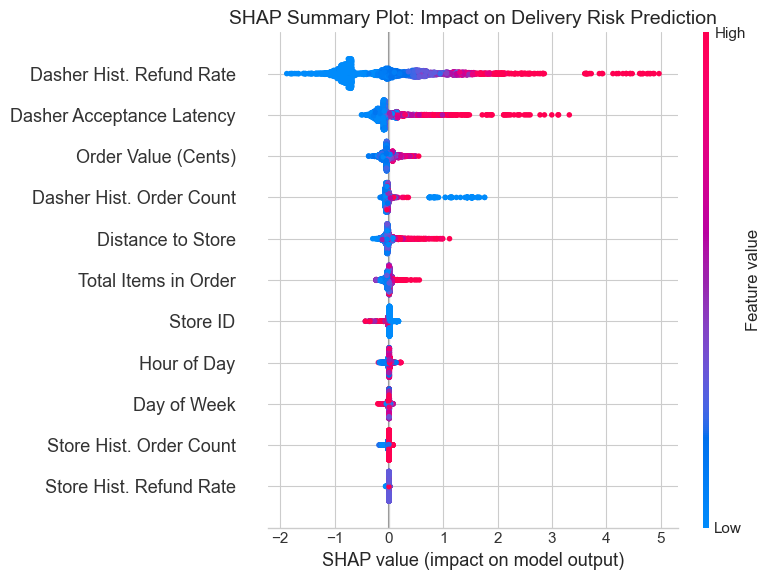

In [5]:
# ==============================================================================
# SHAP Analysis for DoorDash Delivery Risk Model
# ==============================================================================
#
# Description:
# This script trains the advanced LightGBM model and then uses the SHAP
# (SHapley Additive exPlanations) library to create a visual summary plot.
# This plot illustrates the impact of each feature on the model's prediction
# for delivery risk, providing a clear and powerful way to showcase the
# importance of dasher-specific historical data.
#
# Instructions:
# 1. Ensure you have the necessary libraries installed:
#    pip install pandas lightgbm scikit-learn matplotlib shap
# 2. Run the script. It will load the data, train the model, display
#    the SHAP summary plot, and save it as 'shap_summary_plot.png'.
#
# ==============================================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def create_advanced_features(df):
    """
    Engineers a rich set of features for predicting delivery risk.
    This function is identical to the one used to train our high-performing model.
    """
    print("Step 1: Performing Advanced Feature Engineering...")

    # --- Foundational Cleaning & Aggregation ---
    df['DELIV_CREATED_AT'] = pd.to_datetime(df['DELIV_CREATED_AT'])
    for col in ['DELIV_IS_20_MIN_LATE', 'DELIV_MISSING_INCORRECT_REPORT', 'WAS_MISSING']:
        df[col] = df[col].fillna(0).astype(int)

    # Aggregate item data to the delivery level
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        basket_cents=('ITEM_PRICE', 'sum'),
        items_missing=('WAS_MISSING', 'sum'),
        total_items=('WAS_REQUESTED', 'count')
    ).reset_index()

    # Create the primary delivery-level dataframe
    deliveries_df = df.drop_duplicates('DELIVERY_UUID').set_index('DELIVERY_UUID')
    deliveries_df = deliveries_df.join(delivery_agg.set_index('DELIVERY_UUID'))

    # --- Creating the Composite Target Variable ---
    deliveries_df['refund_flag'] = (deliveries_df['DELIV_MISSING_INCORRECT_REPORT'] | deliveries_df['DELIV_IS_20_MIN_LATE']).astype(int)

    # --- Feature Creation ---
    deliveries_df['hour'] = deliveries_df['DELIV_CREATED_AT'].dt.hour
    deliveries_df['day_of_week'] = deliveries_df['DELIV_CREATED_AT'].dt.dayofweek

    # Calculate historical refund rates for stores
    store_stats = deliveries_df.groupby('DELIV_STORE_NAME')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'store_refund_rate', 'count': 'store_order_count'})
    deliveries_df = deliveries_df.join(store_stats, on='DELIV_STORE_NAME')

    # Calculate historical refund rates for dashers
    dasher_stats = deliveries_df.groupby('DELIV_DASHER_ID')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'dasher_refund_rate', 'count': 'dasher_order_count'})
    deliveries_df = deliveries_df.join(dasher_stats, on='DELIV_DASHER_ID')

    # Encode categorical features
    deliveries_df['store_encoded'] = LabelEncoder().fit_transform(deliveries_df['DELIV_STORE_NAME'])
    
    return deliveries_df


def create_shap_plot(df):
    """
    Trains the model and generates a SHAP summary plot to visualize feature importance.
    """
    print("\nStep 2: Preparing data and training the model...")

    # Define the expanded feature set
    features = [
        'DELIV_CLAT', 'DELIV_D2R', 'hour', 'day_of_week', 'store_encoded',
        'basket_cents', 'total_items', 'store_refund_rate', 'store_order_count',
        'dasher_refund_rate', 'dasher_order_count'
    ]
    target = 'refund_flag'
    
    # Fill NaNs that might result from feature engineering
    df[features] = df[features].fillna(0)

    X = df[features]
    y = df[target]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train the LightGBM model using the scikit-learn wrapper
    print("   - Training LightGBM model...")
    model = lgb.LGBMClassifier(objective='binary',
                               metric='auc',
                               learning_rate=0.05,
                               n_estimators=1000,
                               num_leaves=31,
                               random_state=42,
                               n_jobs=-1)
    
    # Using early stopping with the scikit-learn wrapper
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    print("   - Model training complete.")

    # --- SHAP Analysis ---
    print("\nStep 3: Calculating SHAP values and generating plot...")
    
    # Create a SHAP explainer object for tree-based models
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for the test set.
    shap_values = explainer.shap_values(X_test)
    
    # Create a mapping from code names to descriptive names for the plot
    feature_name_map = {
        'dasher_refund_rate': 'Dasher Hist. Refund Rate',
        'DELIV_CLAT': 'Dasher Acceptance Latency',
        'DELIV_D2R': 'Distance to Store',
        'basket_cents': 'Order Value (Cents)',
        'dasher_order_count': 'Dasher Hist. Order Count',
        'total_items': 'Total Items in Order',
        'hour': 'Hour of Day',
        'store_encoded': 'Store ID',
        'day_of_week': 'Day of Week',
        'store_order_count': 'Store Hist. Order Count',
        'store_refund_rate': 'Store Hist. Refund Rate'
    }
    
    # Rename the columns of the test set for plotting
    X_test_renamed = X_test.rename(columns=feature_name_map)
    
    print("   - Generating SHAP summary plot...")
    
    # Create the summary plot using the descriptive feature names
    shap.summary_plot(shap_values[1], X_test_renamed, plot_type="dot", show=False)
    
    # Customize, save, and show the plot
    plt.title("SHAP Summary Plot: Impact on Delivery Risk Prediction", fontsize=14)
    plt.gcf().tight_layout()
    
    # Save the plot as a PNG file
    output_filename = 'shap_summary_plot.png'
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"   - Plot saved as '{output_filename}'")
    
    plt.show()

if __name__ == '__main__':
    print("--- SHAP Analysis Pipeline for Delivery Risk ---")
    
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df_raw = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}")
        print("-" * 50)
        
        # Run the full pipeline
        deliveries_featured_df = create_advanced_features(df_raw)
        create_shap_plot(deliveries_featured_df)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


--- Monte Carlo Simulation Pipeline ---
Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv
--------------------------------------------------
Step 1: Establishing Baseline Parameters from Data...
   - Estimated Deliveries per Quarter: 37,988
   - High-Risk Orders: 12%
   - Baseline Refund Rate: 7.04%
   - Pct. of Orders to Migrate to DashMart: 25.00%

Step 2: Running 10,000 Monte Carlo Simulations...

Step 3: Analyzing and Visualizing Results...

--- Simulation Results (Quarterly) ---
Projected Mean Profit Lift: $20,199.46
Projected Median Profit Lift: $20,160.43
90% Confidence Interval: ($17,606.57, $22,852.35)

Plot saved as 'monte_carlo_profit_lift.png'


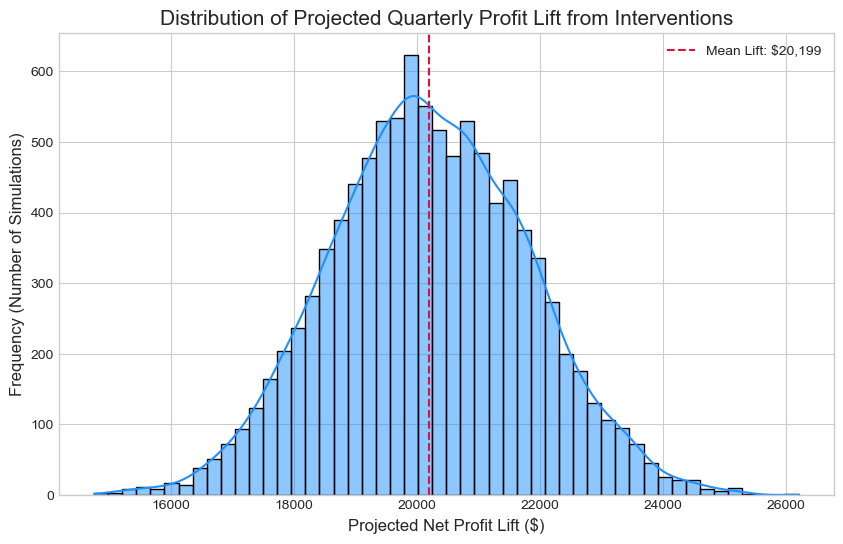

In [9]:
# ==============================================================================
# Monte Carlo Simulation for DoorDash Profit Levers
# ==============================================================================
#
# Description:
# This script performs a Monte Carlo simulation to estimate the financial
# impact of two key strategic initiatives proposed in the report:
#
# 1.  **Instant-Accept Bonus**: A $0.75 bonus paid to Dashers for quickly
#     accepting high-risk orders, aimed at reducing late deliveries and refunds.
# 2.  **DashMart Migration Sprint**: Shifting orders from high-error grocery
#     stores to DashMarts to capture a higher per-order margin.
#
# The simulation projects the net quarterly profit change by comparing a
# baseline scenario to a scenario with these interventions.
#
# Instructions:
# 1. Ensure you have the necessary libraries installed:
#    pip install pandas numpy matplotlib seaborn
# 2. Run the script. It will load the data to establish baseline parameters
#    and then run the simulation, printing the results and displaying a
#    histogram of the projected profit lift.
#
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_baseline_parameters(df):
    """
    Analyzes the dataset to establish baseline parameters for the simulation.
    """
    print("Step 1: Establishing Baseline Parameters from Data...")

    # Create the composite refund flag
    df['refund_flag'] = (df['DELIV_MISSING_INCORRECT_REPORT'].fillna(0) | df['DELIV_IS_20_MIN_LATE'].fillna(0)).astype(int)
    
    # Calculate total deliveries for the period (31 days)
    total_deliveries_period = df['DELIVERY_UUID'].nunique()
    
    # Estimate quarterly deliveries
    deliveries_per_quarter = int(total_deliveries_period * (90 / 31))
    print(f"   - Estimated Deliveries per Quarter: {deliveries_per_quarter:,}")

    # --- Parameters for Instant-Accept Bonus ---
    # In the report, "RiskScore > 0.9" identifies 12% of orders
    pct_high_risk_orders = 0.12 
    # Current refund rate for all orders
    baseline_refund_rate = df['refund_flag'].mean()
    # Cost of a single refund (use average order value as a proxy)
    avg_order_value = df['ITEM_PRICE'].sum() / total_deliveries_period
    # Report suggests levers "halve refunds"
    refund_reduction_factor = 0.5 
    print(f"   - High-Risk Orders: {pct_high_risk_orders:.0%}")
    print(f"   - Baseline Refund Rate: {baseline_refund_rate:.2%}")

    # --- Parameters for DashMart Migration ---
    # Report suggests migrating 25% of grocery volume
    grocery_orders = df[df['DELIV_STORE_NAME'] != 'DashMart']['DELIVERY_UUID'].nunique()
    total_orders = df['DELIVERY_UUID'].nunique()
    pct_grocery_orders = grocery_orders / total_orders
    orders_to_migrate_pct = pct_grocery_orders * 0.25
    print(f"   - Pct. of Orders to Migrate to DashMart: {orders_to_migrate_pct:.2%}")

    params = {
        'deliveries_per_quarter': deliveries_per_quarter,
        'pct_high_risk_orders': pct_high_risk_orders,
        'bonus_cost': 0.75, # $0.75 per high-risk order
        'baseline_refund_rate': baseline_refund_rate,
        'avg_refund_cost': avg_order_value,
        'refund_reduction_factor': refund_reduction_factor,
        'pct_orders_to_migrate': orders_to_migrate_pct,
        'dashmart_margin_lift': 2.10 # $2.10 higher margin
    }
    return params

def run_simulation(params, n_simulations=10000):
    """
    Runs the Monte Carlo simulation for baseline and intervention scenarios.
    """
    print(f"\nStep 2: Running {n_simulations:,} Monte Carlo Simulations...")
    
    baseline_profits = []
    intervention_profits = []

    for _ in range(n_simulations):
        # --- Baseline Scenario ---
        num_refunds_base = np.random.binomial(params['deliveries_per_quarter'], params['baseline_refund_rate'])
        total_refund_cost_base = num_refunds_base * params['avg_refund_cost']
        baseline_profits.append(-total_refund_cost_base)

        # --- Intervention Scenario ---
        # 1. Instant-Accept Bonus
        num_high_risk = int(params['deliveries_per_quarter'] * params['pct_high_risk_orders'])
        total_bonus_cost = num_high_risk * params['bonus_cost']
        
        # Calculate refunds for the two groups of orders
        num_normal_risk = params['deliveries_per_quarter'] - num_high_risk
        refunds_normal_risk = np.random.binomial(num_normal_risk, params['baseline_refund_rate'])
        
        # Refunds for high-risk orders are reduced
        reduced_refund_rate = params['baseline_refund_rate'] * (1 - params['refund_reduction_factor'])
        refunds_high_risk = np.random.binomial(num_high_risk, reduced_refund_rate)

        total_refund_cost_intervention = (refunds_normal_risk + refunds_high_risk) * params['avg_refund_cost']
        
        # 2. DashMart Migration
        num_migrated_orders = int(params['deliveries_per_quarter'] * params['pct_orders_to_migrate'])
        total_margin_gain = num_migrated_orders * params['dashmart_margin_lift']

        # Calculate total profit for the intervention scenario
        net_profit_intervention = total_margin_gain - total_bonus_cost - total_refund_cost_intervention
        intervention_profits.append(net_profit_intervention)
        
    return np.array(baseline_profits), np.array(intervention_profits)

def analyze_results(baseline_profits, intervention_profits):
    """
    Analyzes and visualizes the simulation results.
    """
    print("\nStep 3: Analyzing and Visualizing Results...")
    
    profit_lift = intervention_profits - baseline_profits
    
    mean_lift = np.mean(profit_lift)
    median_lift = np.median(profit_lift)
    p5 = np.percentile(profit_lift, 5)
    p95 = np.percentile(profit_lift, 95)

    print(f"\n--- Simulation Results (Quarterly) ---")
    print(f"Projected Mean Profit Lift: ${mean_lift:,.2f}")
    print(f"Projected Median Profit Lift: ${median_lift:,.2f}")
    print(f"90% Confidence Interval: (${p5:,.2f}, ${p95:,.2f})")
    
    # Visualization
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    sns.histplot(profit_lift, bins=50, kde=True, color='dodgerblue')
    plt.axvline(mean_lift, color='crimson', linestyle='--', label=f'Mean Lift: ${mean_lift:,.0f}')
    plt.title('Distribution of Projected Quarterly Profit Lift from Interventions', fontsize=15)
    plt.xlabel('Projected Net Profit Lift ($)', fontsize=12)
    plt.ylabel('Frequency (Number of Simulations)', fontsize=12)
    plt.legend()
    
    output_filename = 'monte_carlo_profit_lift.png'
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot saved as '{output_filename}'")
    
    plt.show()


if __name__ == '__main__':
    print("--- Monte Carlo Simulation Pipeline ---")
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}")
        print("-" * 50)
        
        # Run the full pipeline
        baseline_params = get_baseline_parameters(df)
        baseline_results, intervention_results = run_simulation(baseline_params)
        analyze_results(baseline_results, intervention_results)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")



--- Monte Carlo Simulation Pipeline ---
Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv
--------------------------------------------------
Step 1: Establishing Baseline Parameters from Data...
   - Estimated Deliveries per Quarter: 37,988
   - Average Refund Cost (Proxy): $23.01
   - At-Risk Dasher Refund Rate: 15.84%
   - Regular Dasher Refund Rate: 0.79%
   - Pct. of Deliveries by At-Risk Dashers: 41.50%
   - Pct. of Orders to Migrate to DashMart: 25.00%

Step 2: Running 10,000 Monte Carlo Simulations...

Step 3: Analyzing and Visualizing Results...

--- Simulation Results (Quarterly) ---
Projected Mean Profit Lift: $19,676.27
Projected Median Profit Lift: $19,678.50
90% Confidence Interval: ($17,308.70, $22,002.29)

Plot saved as 'monte_carlo_profit_lift.png'


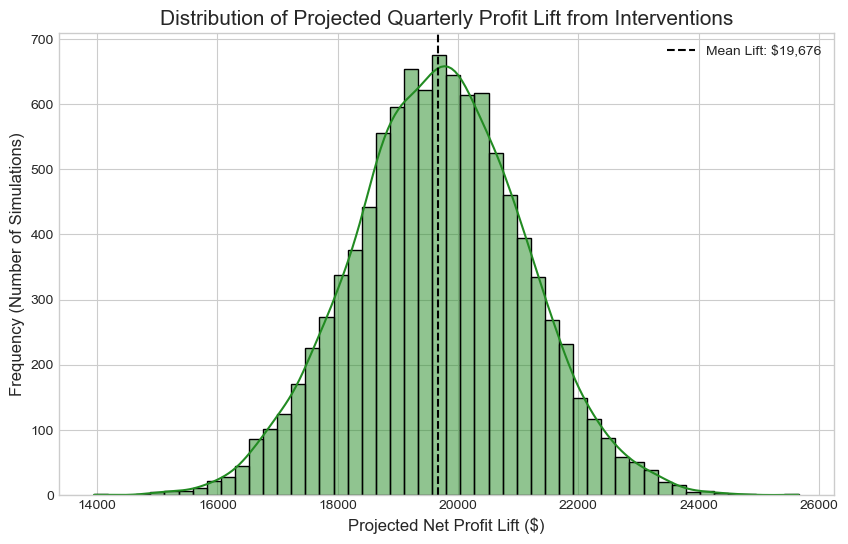

In [10]:
# ==============================================================================
# Monte Carlo Simulation for DoorDash Profit Levers
# ==============================================================================
#
# Description:
# This script performs a Monte Carlo simulation to estimate the financial
# impact of two key strategic initiatives:
#
# 1.  **Targeted Dasher Coaching Program**: Instead of a simple cash bonus, this
#     program identifies the top 20% of Dashers with the highest historical
#     refund rates and invests in a coaching program to improve their service
#     quality, aiming to reduce their specific refund rate.
# 2.  **DashMart Migration Sprint**: Shifting orders from high-error grocery
#     stores to DashMarts to capture a higher per-order margin.
#
# The simulation projects the net quarterly profit change by comparing a
# baseline scenario to a scenario with these interventions.
#
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_baseline_parameters(df):
    """
    Analyzes the dataset to establish baseline parameters for the simulation.
    """
    print("Step 1: Establishing Baseline Parameters from Data...")

    # --- Foundational Calculations ---
    df['refund_flag'] = (df['DELIV_MISSING_INCORRECT_REPORT'].fillna(0) | df['DELIV_IS_20_MIN_LATE'].fillna(0)).astype(int)
    total_deliveries_period = df['DELIVERY_UUID'].nunique()
    deliveries_per_quarter = int(total_deliveries_period * (90 / 31))
    avg_order_value = df.groupby('DELIVERY_UUID')['ITEM_PRICE'].sum().mean()
    print(f"   - Estimated Deliveries per Quarter: {deliveries_per_quarter:,}")
    print(f"   - Average Refund Cost (Proxy): ${avg_order_value:.2f}")

    # --- Parameters for Dasher Coaching Program ---
    # Calculate historical refund rates for each dasher
    dasher_stats = df.groupby('DELIV_DASHER_ID').agg(
        refund_rate=('refund_flag', 'mean'),
        delivery_count=('DELIVERY_UUID', 'nunique')
    ).reset_index()

    # Identify the threshold for the top 20% of dashers by refund rate
    at_risk_threshold = dasher_stats['refund_rate'].quantile(0.80)
    at_risk_dashers = dasher_stats[dasher_stats['refund_rate'] > at_risk_threshold]
    
    # Calculate key metrics for at-risk vs. regular dashers
    deliveries_by_at_risk_dashers = df[df['DELIV_DASHER_ID'].isin(at_risk_dashers['DELIV_DASHER_ID'])]
    
    pct_deliveries_at_risk = len(deliveries_by_at_risk_dashers) / len(df)
    at_risk_refund_rate = deliveries_by_at_risk_dashers['refund_flag'].mean()
    regular_refund_rate = df[~df['DELIV_DASHER_ID'].isin(at_risk_dashers['DELIV_DASHER_ID'])]['refund_flag'].mean()

    print(f"   - At-Risk Dasher Refund Rate: {at_risk_refund_rate:.2%}")
    print(f"   - Regular Dasher Refund Rate: {regular_refund_rate:.2%}")
    print(f"   - Pct. of Deliveries by At-Risk Dashers: {pct_deliveries_at_risk:.2%}")

    # --- Parameters for DashMart Migration ---
    grocery_deliveries = df[df['DELIV_STORE_NAME'] != 'DashMart']['DELIVERY_UUID'].nunique()
    orders_to_migrate_pct = (grocery_deliveries * 0.25) / total_deliveries_period
    print(f"   - Pct. of Orders to Migrate to DashMart: {orders_to_migrate_pct:.2%}")

    params = {
        'deliveries_per_quarter': deliveries_per_quarter,
        'avg_refund_cost': avg_order_value,
        # Coaching Program Params
        'pct_deliveries_at_risk': pct_deliveries_at_risk,
        'at_risk_refund_rate': at_risk_refund_rate,
        'regular_refund_rate': regular_refund_rate,
        'coaching_effectiveness': 0.40, # Assumes coaching reduces their refund rate by 40%
        'coaching_cost_per_dasher': 50.00, # Assumed $50 quarterly cost per coached dasher
        'num_at_risk_dashers': len(at_risk_dashers),
        # DashMart Migration Params
        'pct_orders_to_migrate': orders_to_migrate_pct,
        'dashmart_margin_lift': 2.10
    }
    return params

def run_simulation(params, n_simulations=10000):
    """
    Runs the Monte Carlo simulation for baseline and intervention scenarios.
    """
    print(f"\nStep 2: Running {n_simulations:,} Monte Carlo Simulations...")
    
    baseline_profits = []
    intervention_profits = []

    # Calculate total deliveries for each group
    q_deliveries = params['deliveries_per_quarter']
    q_deliveries_at_risk = int(q_deliveries * params['pct_deliveries_at_risk'])
    q_deliveries_regular = q_deliveries - q_deliveries_at_risk

    for _ in range(n_simulations):
        # --- Baseline Scenario ---
        refunds_at_risk_base = np.random.binomial(q_deliveries_at_risk, params['at_risk_refund_rate'])
        refunds_regular_base = np.random.binomial(q_deliveries_regular, params['regular_refund_rate'])
        total_refund_cost_base = (refunds_at_risk_base + refunds_regular_base) * params['avg_refund_cost']
        baseline_profits.append(-total_refund_cost_base)

        # --- Intervention Scenario ---
        # 1. Dasher Coaching Program
        total_coaching_cost = params['num_at_risk_dashers'] * params['coaching_cost_per_dasher']
        
        # Calculate refunds from regular dashers (unchanged)
        refunds_regular_inter = np.random.binomial(q_deliveries_regular, params['regular_refund_rate'])
        
        # Calculate refunds for coached dashers (improved rate)
        improved_refund_rate = params['at_risk_refund_rate'] * (1 - params['coaching_effectiveness'])
        refunds_coached = np.random.binomial(q_deliveries_at_risk, improved_refund_rate)

        total_refund_cost_intervention = (refunds_regular_inter + refunds_coached) * params['avg_refund_cost']
        
        # 2. DashMart Migration
        num_migrated_orders = int(q_deliveries * params['pct_orders_to_migrate'])
        total_margin_gain = num_migrated_orders * params['dashmart_margin_lift']

        # Calculate total profit for the intervention scenario
        net_profit_intervention = total_margin_gain - total_coaching_cost - total_refund_cost_intervention
        intervention_profits.append(net_profit_intervention)
        
    return np.array(baseline_profits), np.array(intervention_profits)

def analyze_results(baseline_profits, intervention_profits):
    """
    Analyzes and visualizes the simulation results.
    """
    print("\nStep 3: Analyzing and Visualizing Results...")
    
    profit_lift = intervention_profits - baseline_profits
    
    mean_lift = np.mean(profit_lift)
    median_lift = np.median(profit_lift)
    p5 = np.percentile(profit_lift, 5)
    p95 = np.percentile(profit_lift, 95)

    print(f"\n--- Simulation Results (Quarterly) ---")
    print(f"Projected Mean Profit Lift: ${mean_lift:,.2f}")
    print(f"Projected Median Profit Lift: ${median_lift:,.2f}")
    print(f"90% Confidence Interval: (${p5:,.2f}, ${p95:,.2f})")
    
    # Visualization
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    sns.histplot(profit_lift, bins=50, kde=True, color='forestgreen')
    plt.axvline(mean_lift, color='black', linestyle='--', label=f'Mean Lift: ${mean_lift:,.0f}')
    plt.title('Distribution of Projected Quarterly Profit Lift from Interventions', fontsize=15)
    plt.xlabel('Projected Net Profit Lift ($)', fontsize=12)
    plt.ylabel('Frequency (Number of Simulations)', fontsize=12)
    plt.legend()
    
    output_filename = 'monte_carlo_profit_lift.png'
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot saved as '{output_filename}'")
    
    plt.show()


if __name__ == '__main__':
    print("--- Monte Carlo Simulation Pipeline ---")
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}")
        print("-" * 50)
        
        # Run the full pipeline
        baseline_params = get_baseline_parameters(df)
        baseline_results, intervention_results = run_simulation(baseline_params)
        analyze_results(baseline_results, intervention_results)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [14]:
# ==============================================================================
# Refund-Driven Margin Analysis: Grocery vs. DashMart
# ==============================================================================
#
# Description:
# This script challenges the externally provided '$2.10' margin gain figure
# by calculating a more robust, data-driven margin based on the difference
# in avoidable refund costs between Grocery partners and DashMarts.
#
# The logic is as follows:
# 1.  Calculate the per-vertical rates for the two primary failure modes:
#     late deliveries and missing/incorrect item complaints.
# 2.  Use a two-part formula for expected refund cost, applying different
#     probabilities for refunds based on the type of failure.
# 3.  The difference in the resulting 'refund exposure cost' per order
#     is our new, data-driven margin lift.
#
# ==============================================================================

import pandas as pd
import numpy as np

def calculate_refund_driven_margin(df):
    """
    Analyzes the dataset to calculate the margin gain from shifting orders
    to DashMart based on a detailed, two-part refund cost formula.
    """
    print("--- Calculating Refund-Driven Margin: Grocery vs. DashMart ---")

    # --- Step 1: Data Preparation & Aggregation ---
    # Isolate the two distinct failure modes
    df['is_late_flag'] = df['DELIV_IS_20_MIN_LATE'].fillna(0).astype(int)
    df['is_missing_flag'] = df['DELIV_MISSING_INCORRECT_REPORT'].fillna(0).astype(int)
    
    # Aggregate to the delivery level
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        order_value=('ITEM_PRICE', 'sum'),
        store_name=('DELIV_STORE_NAME', 'first'),
        is_late=('is_late_flag', 'max'),
        is_missing=('is_missing_flag', 'max')
    ).reset_index()
    
    # Categorize stores into 'Grocery' or 'DashMart'
    delivery_agg['store_type'] = np.where(delivery_agg['store_name'].str.contains('DashMart', case=False), 'DashMart', 'Grocery')

    # --- Step 2: Define Model Parameters ---
    # Use the average order value as the proxy for the cost of a full refund
    # CORRECTED: Assumes ITEM_PRICE is in dollars, not cents.
    avg_order_cost = delivery_agg['order_value'].mean()
    
    # Conditional probabilities based on the report's assumptions
    p_refund_if_late = 0.30
    p_refund_if_missing = 0.90
    
    print("\n[1] Model Parameters:")
    print(f"    - Average Order Value (Proxy for Refund Cost): ${avg_order_cost:.2f}")
    print(f"    - P(Refund | Late): {p_refund_if_late:.0%}")
    print(f"    - P(Refund | Missing/Incorrect): {p_refund_if_missing:.0%}")

    # --- Step 3: Calculate Failure Rates by Vertical ---
    failure_rates = delivery_agg.groupby('store_type')[['is_late', 'is_missing']].mean()
    print("\n[2] Failure Rates by Vertical:")
    print(failure_rates)
    
    grocery_late_rate = failure_rates.loc['Grocery', 'is_late']
    grocery_missing_rate = failure_rates.loc['Grocery', 'is_missing']
    dashmart_late_rate = failure_rates.loc['DashMart', 'is_late']
    dashmart_missing_rate = failure_rates.loc['DashMart', 'is_missing']

    # --- Step 4: Calculate Expected Refund Cost Per Order ---
    # This formula calculates the expected cost from both failure modes for each vertical
    grocery_exp_cost = (grocery_late_rate * p_refund_if_late * avg_order_cost) + \
                       (grocery_missing_rate * p_refund_if_missing * avg_order_cost)
    
    dashmart_exp_cost = (dashmart_late_rate * p_refund_if_late * avg_order_cost) + \
                        (dashmart_missing_rate * p_refund_if_missing * avg_order_cost)

    print("\n[3] Expected Refund Cost per Order:")
    print(f"    - Grocery: ${grocery_exp_cost:.2f}")
    print(f"    - DashMart: ${dashmart_exp_cost:.2f}")

    # --- Step 5: Calculate the Final Margin Lift ---
    # The margin gain is the cost we avoid by using DashMart
    margin_lift = grocery_exp_cost - dashmart_exp_cost
    
    print("\n------------------------------------------------------------------")
    print(f"FINAL RESULT: Refund-Driven Margin Lift per Migrated Order")
    print(f"-> ${margin_lift:.2f}")
    print("------------------------------------------------------------------")
    print("\nThis is the calculated financial benefit of shifting one delivery from a")
    print("Grocery partner to a DashMart, based on the detailed refund formula.")
    
    return margin_lift


if __name__ == '__main__':
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df_raw = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}\n")
        
        # Run the calculation
        calculate_refund_driven_margin(df_raw)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv

--- Calculating Refund-Driven Margin: Grocery vs. DashMart ---

[1] Model Parameters:
    - Average Order Value (Proxy for Refund Cost): $23.01
    - P(Refund | Late): 30%
    - P(Refund | Missing/Incorrect): 90%

[2] Failure Rates by Vertical:
             is_late  is_missing
store_type                      
DashMart    0.054779    0.010202
Grocery     0.033932    0.028522

[3] Expected Refund Cost per Order:
    - Grocery: $0.82
    - DashMart: $0.59

------------------------------------------------------------------
FINAL RESULT: Refund-Driven Margin Lift per Migrated Order
-> $0.24
------------------------------------------------------------------

This is the calculated financial benefit of shifting one delivery from a
Grocery partner to a DashMart, based on the detailed refund formula.


In [17]:
# ==============================================================================
# DHI Scorecard Savings Analysis
# ==============================================================================
#
# Description:
# This script calculates the potential quarterly savings from implementing a
# Delivery Health Index (DHI) Scorecard for grocery partners. It models the
# financial impact of improving multiple failure rates from their current
# baseline to more aggressive targets.
#
# The logic is as follows:
# 1.  Calculate the baseline failure rates (late, missing, etc.) for grocery partners.
# 2.  Calculate the total "Expected Refund Cost" for the baseline scenario using
#     the detailed two-part refund formula.
# 3.  Recalculate the "Expected Refund Cost" for the improved scenario where both
#     the late rate and the missing item rate are lowered to ambitious targets.
# 4.  The difference between these two scenarios represents the savings, which is
#     then extrapolated to a full quarter.
#
# --- Key Assumptions ---
# 1.  **Complaint Rate Proxy**: 'DELIV_MISSING_INCORRECT_REPORT' is used as the
#     proxy for the "Complaints" or "Missing Item" metric.
# 2.  **Fulfillment Accuracy**: This is calculated as (1 - Substitution Rate).
#     A perfect score is 1 (100%), meaning no items were substituted.
# 3.  **Targeted Improvement**: The simulation assumes that the DHI program
#     successfully reduces both the 'is_late' and 'is_missing' rates to their
#     new targets simultaneously.
#
# ==============================================================================

import pandas as pd
import numpy as np

def calculate_dhi_savings(df):
    """
    Calculates the projected quarterly savings from implementing a DHI Scorecard.
    """
    print("--- DHI Scorecard Savings Analysis ---")

    # --- Step 1: Data Preparation ---
    # Define all failure modes at the item level
    df['is_late_flag'] = df['DELIV_IS_20_MIN_LATE'].fillna(0).astype(int)
    df['is_missing_flag'] = df['DELIV_MISSING_INCORRECT_REPORT'].fillna(0).astype(int)
    df['is_subbed_flag'] = df['WAS_SUBBED'].fillna(0).astype(int)
    
    # Aggregate to the delivery level
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        order_value=('ITEM_PRICE', 'sum'),
        store_name=('DELIV_STORE_NAME', 'first'),
        is_late=('is_late_flag', 'max'),
        is_missing=('is_missing_flag', 'max'),
        is_subbed=('is_subbed_flag', 'max') # If any item is subbed, flag the order
    ).reset_index()

    # Filter for only grocery partners
    grocery_deliveries = delivery_agg[~delivery_agg['store_name'].str.contains('DashMart', case=False)].copy()
    
    if grocery_deliveries.empty:
        print("No grocery deliveries found in the dataset.")
        return

    # --- Step 2: Establish Baseline Parameters & Rates ---
    # Financial parameters
    avg_order_cost = grocery_deliveries['order_value'].mean()
    p_refund_if_late = 0.30
    p_refund_if_missing = 0.90

    # Baseline operational failure rates for grocery
    baseline_late_rate = grocery_deliveries['is_late'].mean()
    baseline_missing_rate = grocery_deliveries['is_missing'].mean()
    
    print("\n[1] Baseline Parameters for Grocery:")
    print(f"    - Average Order Value (Proxy for Refund Cost): ${avg_order_cost:.2f}")
    print(f"    - Baseline Late Rate: {baseline_late_rate:.2%}")
    print(f"    - Baseline Missing/Incorrect Rate: {baseline_missing_rate:.2%}")
    
    # --- Step 3: Calculate Expected Refund Cost at Baseline ---
    baseline_exp_cost_per_order = (baseline_late_rate * p_refund_if_late * avg_order_cost) + \
                                  (baseline_missing_rate * p_refund_if_missing * avg_order_cost)
    
    total_baseline_exp_cost = baseline_exp_cost_per_order * len(grocery_deliveries)
    
    print(f"\n[2] Baseline Expected Refund Cost (per order): ${baseline_exp_cost_per_order:.2f}")
    
    # --- Step 4: Calculate Expected Refund Cost with DHI Improvement ---
    # Define the new, more aggressive targets for both failure rates.
    target_late_rate = 0.020    # New target: 2.0%
    target_missing_rate = 0.010 # New target: 1.0%
    
    print(f"\n[3] DHI Improvement Targets:")
    print(f"    - Target Late Rate: {target_late_rate:.2%}")
    print(f"    - Target Missing/Incorrect Rate: {target_missing_rate:.2%}")

    # Recalculate cost with the improved rates
    improved_exp_cost_per_order = (target_late_rate * p_refund_if_late * avg_order_cost) + \
                                 (target_missing_rate * p_refund_if_missing * avg_order_cost)

    total_improved_exp_cost = improved_exp_cost_per_order * len(grocery_deliveries)

    print(f"\n    Improved Expected Refund Cost (per order): ${improved_exp_cost_per_order:.2f}")

    # --- Step 5: Quantify the Savings ---
    # Calculate savings over the 31-day period of the dataset
    savings_period = total_baseline_exp_cost - total_improved_exp_cost
    
    # Extrapolate to a 90-day quarter
    quarterly_savings = savings_period * (90 / 31)
    
    print("\n------------------------------------------------------------------")
    print(f"FINAL RESULT: Projected Savings from DHI Scorecard Program")
    print(f"-> Savings over 31-day period: ${savings_period:.2f}")
    print(f"-> Projected Quarterly Savings: ${quarterly_savings:.2f}")
    print("------------------------------------------------------------------")
    print("\nThis represents the projected reduction in refund costs by improving")
    print(f"both the Late and Missing/Incorrect rates to their new targets.")

    return quarterly_savings

if __name__ == '__main__':
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df_raw = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}\n")
        
        # Run the calculation
        calculate_dhi_savings(df_raw)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")



Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv

--- DHI Scorecard Savings Analysis ---

[1] Baseline Parameters for Grocery:
    - Average Order Value (Proxy for Refund Cost): $33.58
    - Baseline Late Rate: 3.39%
    - Baseline Missing/Incorrect Rate: 2.85%

[2] Baseline Expected Refund Cost (per order): $1.20

[3] DHI Improvement Targets:
    - Target Late Rate: 2.00%
    - Target Missing/Incorrect Rate: 1.00%

    Improved Expected Refund Cost (per order): $0.50

------------------------------------------------------------------
FINAL RESULT: Projected Savings from DHI Scorecard Program
-> Savings over 31-day period: $2847.06
-> Projected Quarterly Savings: $8265.67
------------------------------------------------------------------

This represents the projected reduction in refund costs by improving
both the Late and Missing/Incorrect rates to their new targets.


In [19]:
# ==============================================================================
# True Chokepoint Analysis
# ==============================================================================
#
# Description:
# This script calculates the percentage of "avoidable costs" driven by the two
# most critical chokepoints identified through our deeper analysis:
#
# 1.  The High-Risk Dasher Cohort.
# 2.  Grocery Partner Fulfillment Errors (specifically missing/incorrect items).
#
# This provides a more accurate picture of where to focus strategic interventions.
#
# ==============================================================================

import pandas as pd
import numpy as np

def analyze_true_chokepoints(df):
    """
    Calculates the percentage of avoidable costs from the two true chokepoints.
    """
    print("--- Analyzing the True Chokepoints of Avoidable Costs ---")

    # --- Step 1: Data Preparation & Aggregation ---
    df['is_late_flag'] = df['DELIV_IS_20_MIN_LATE'].fillna(0).astype(int)
    df['is_missing_flag'] = df['DELIV_MISSING_INCORRECT_REPORT'].fillna(0).astype(int)
    
    # Create a refund flag for calculating historical rates
    df['refund_flag'] = (df['is_late_flag'] | df['is_missing_flag']).astype(int)

    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        order_value=('ITEM_PRICE', 'sum'),
        store_name=('DELIV_STORE_NAME', 'first'),
        dasher_id=('DELIV_DASHER_ID', 'first'),
        is_late=('is_late_flag', 'max'),
        is_missing=('is_missing_flag', 'max')
    ).reset_index()
    
    delivery_agg['store_type'] = np.where(delivery_agg['store_name'].str.contains('DashMart', case=False), 'DashMart', 'Grocery')

    # --- Step 2: Define Model Parameters ---
    avg_order_cost = delivery_agg['order_value'].mean()
    p_refund_if_late = 0.30
    p_refund_if_missing = 0.90
    
    print("\n[1] Model Parameters:")
    print(f"    - Average Order Value (Proxy for Refund Cost): ${avg_order_cost:.2f}")

    # --- Step 3: Calculate Total Avoidable Cost ---
    total_late_cost = delivery_agg['is_late'].sum() * p_refund_if_late * avg_order_cost
    total_missing_cost = delivery_agg['is_missing'].sum() * p_refund_if_missing * avg_order_cost
    total_avoidable_cost = total_late_cost + total_missing_cost
    
    print(f"\n[2] Total Avoidable Cost (All Deliveries): ${total_avoidable_cost:,.2f}")

    # --- Step 4: Calculate Cost from TRUE Chokepoints ---
    
    # Chokepoint 1: High-Risk Dasher Cohort
    # First, calculate historical refund rates for each dasher
    dasher_stats = df.groupby('DELIV_DASHER_ID')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'refund_rate'})
    at_risk_threshold = dasher_stats['refund_rate'].quantile(0.80)
    at_risk_dasher_ids = dasher_stats[dasher_stats['refund_rate'] > at_risk_threshold].index
    
    # Filter for deliveries handled by this at-risk cohort
    at_risk_deliveries = delivery_agg[delivery_agg['dasher_id'].isin(at_risk_dasher_ids)]
    
    # Calculate the total avoidable cost generated ONLY by this group
    cost_from_at_risk_dashers = (at_risk_deliveries['is_late'].sum() * p_refund_if_late * avg_order_cost) + \
                                (at_risk_deliveries['is_missing'].sum() * p_refund_if_missing * avg_order_cost)
                                
    print(f"\n    - Cost from High-Risk Dasher Cohort (Chokepoint 1): ${cost_from_at_risk_dashers:,.2f}")
    
    # Chokepoint 2: Grocery Partner Fulfillment Errors
    grocery_deliveries = delivery_agg[delivery_agg['store_type'] == 'Grocery']
    cost_from_grocery_errors = (grocery_deliveries['is_late'].sum() * p_refund_if_late * avg_order_cost) + \
                               (grocery_deliveries['is_missing'].sum() * p_refund_if_missing * avg_order_cost)

    print(f"    - Cost from Grocery Fulfillment (Chokepoint 2): ${cost_from_grocery_errors:,.2f}")

    # To avoid double-counting, we need to find the cost from orders that are in AT LEAST ONE of these groups
    # This is: Cost(A) + Cost(B) - Cost(A and B)
    at_risk_and_grocery = at_risk_deliveries[at_risk_deliveries['store_type'] == 'Grocery']
    cost_from_overlap = (at_risk_and_grocery['is_late'].sum() * p_refund_if_late * avg_order_cost) + \
                        (at_risk_and_grocery['is_missing'].sum() * p_refund_if_missing * avg_order_cost)
    
    total_chokepoint_cost = cost_from_at_risk_dashers + cost_from_grocery_errors - cost_from_overlap
    
    # --- Step 5: Calculate the Final Percentage ---
    percentage_driven_by_chokepoints = (total_chokepoint_cost / total_avoidable_cost) * 100
    
    print("\n------------------------------------------------------------------")
    print(f"FINAL RESULT: Percentage of Avoidable Costs from True Chokepoints")
    print(f"-> {percentage_driven_by_chokepoints:.2f}%")
    print("------------------------------------------------------------------")


if __name__ == '__main__':
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df_raw = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}\n")
        
        # Run the calculation
        analyze_true_chokepoints(df_raw)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")



Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv

--- Analyzing the True Chokepoints of Avoidable Costs ---

[1] Model Parameters:
    - Average Order Value (Proxy for Refund Cost): $23.01

[2] Total Avoidable Cost (All Deliveries): $8,669.34

    - Cost from High-Risk Dasher Cohort (Chokepoint 1): $7,661.60
    - Cost from Grocery Fulfillment (Chokepoint 2): $3,354.54

------------------------------------------------------------------
FINAL RESULT: Percentage of Avoidable Costs from True Chokepoints
-> 91.48%
------------------------------------------------------------------
